<a href="https://www.kaggle.com/code/park4264/bike-prediction-eda?scriptVersionId=121302571" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Bike Sharing Demand 🚲 
# EDA

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/bike-sharing-demand/sampleSubmission.csv
/kaggle/input/bike-sharing-demand/train.csv
/kaggle/input/bike-sharing-demand/test.csv


# 1. 데이터 불러오기

In [2]:
data_path = '/kaggle/input/bike-sharing-demand/'

In [3]:
train = pd.read_csv(data_path + 'train.csv') # 훈련 데이터
test = pd.read_csv(data_path + 'test.csv') # 테스트 데이터

In [4]:
submission = pd.read_csv(data_path + 'sampleSubmission.csv') # 제출 샘플 데이터

In [5]:
# 훈련데이터와 테스트 데이터 크기를 확인

train.shape, test.shape

((10886, 12), (6493, 9))

- 훈련 데이터는 10,886행 **12열**로 구성
- 테스트 데이터는 6,493행 **9열**로 구성
- ❓ Note that: 피처의 개수가 서로 다르다
    - 어떤 피처 데이터를 담고있는지 살펴봅시다

In [6]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


### 경진대회 데이터의 피처들

- `datetime`: 기록 일시 (1시간 간격)
- `season`: 계절
    - 1: 봄
    - 2: 여름
    - 3: 가을
    - 4: 겨울
- `holiday`: 공휴일 여부
    - 0: 공휴일 아님
    - 1: 공휴일
- `workingday`: 근무일 여부
    - 0: 근무일 아님
    - 1: 근무일
    - 주말과 공휴일이 아니면 근무일이라고 간주
- `weather`: 날씨
    - 1: 맑음
    - 2: 옅은 안개, 약간 흐림
    - 3: 약간의 눈, 약간의 비와 천둥 번개, 흐림
    - 4: 폭우와 천둥 번개, 눈과 짙은 안개
    - 숫자가 클수록 날씨가 안 좋음
- `temp`: 실제 온도
- `atemp`: 체감 온도
- `humidity`: 상대 습도
- `windspeed`: 풍속
- `casual`: 등록되지 않은 사용자(비회원) 수
- `registered`: 등록된 사용자(회원) 수
- `count`: 자전거 대여 수량
    - $\Rightarrow$**예측해야 할 값**: 시간당 총 자전거 대여 수량

In [7]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


- 테스트 데이터는 피처 수가 훈련 데이터보다 적다
    - `casual`과 `registered`가 빠짐
    - 모델을 훈련할 떄에도 빼야 한다.

In [8]:
# 제출 샘플 파일
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


- `count`: 시간대별 대여 수량을 예측해 이 값을 바꾼 뒤 제출합시다.
- ID 값 (datetime) 은 데이터를 구분하는 역할만 하므로 이 피처는 제거할 계획

In [9]:
# info() 함수를 사용하면 DataFrame 각 열의 결측값이 몇 개, 데이터 타임은 무엇인지 파악할 수 있다.
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


# 2. 데이터 시각화
## 2-1. Time 변수 전처리

- 데이터를 다양한 관점에서 시각화해보면 raw data 상태에서는 찾기 어려운 경향, 공통점, 차이 등이 드러날 수 있음
- 일부데이터 (`datetime`)은 시각화에 적합하지 않음
    - 적절하게 변환 (피처엔지니어링) 필요
    
    
- `datetime`은 연도, 월, 일, 시간, 분, 초로 구성되어 있다.
- `split()`을 써서 구성요소를 나누어보자

In [10]:
# datetime의 100번째 원소를 예로 들어 어떻게 나누는지 살펴보자
print(train['datetime'][100]) # datetime 100 (101) 번째 원소
print(train['datetime'][100].split()) # 공백 기준으로 문자열 나누기
print(train['datetime'][100].split()[0]) # 날짜
print(train['datetime'][100].split()[1]) # 시간

2011-01-05 09:00:00
['2011-01-05', '09:00:00']
2011-01-05
09:00:00


- `datetime` 피처는 object 타입이므로 문자열처럼 다룰 수 있따.

In [11]:
# 날짜 문자열을 다시 연도, 월, 일로 나누어보자.
print(train['datetime'][100].split()[0]) # 날짜
print(train['datetime'][100].split()[0].split("-")) # "-" 기준으로 문자열 나누니
print(train['datetime'][100].split()[0].split("-")[0]) # 연도
print(train['datetime'][100].split()[0].split("-")[1]) # 월
print(train['datetime'][100].split()[0].split("-")[2]) # 일

2011-01-05
['2011', '01', '05']
2011
01
05


- 다음으로 판다스 `apply()` 함수로 앞의 로직을 `datetime`에 적용해 
    - 날짜 (`date`) 
    - 연도 (`year`)
    - 월 (`month`)
    - 일 (`day`)
    - 시 (`hour`)
    - 분 (`minute`)
    - 초 (`second`)
    
    피처를 생성해보자

In [12]:
train['date'] = train['datetime'].apply(lambda x: x.split()[0]) # 날짜 피처 생성
train['date']

0        2011-01-01
1        2011-01-01
2        2011-01-01
3        2011-01-01
4        2011-01-01
            ...    
10881    2012-12-19
10882    2012-12-19
10883    2012-12-19
10884    2012-12-19
10885    2012-12-19
Name: date, Length: 10886, dtype: object

In [13]:
# 연도, 월, 일, 시, 분, 초 피처를 생성

train['year'] = train['datetime'].apply(lambda x : x.split()[0].split('-')[0])
train['month'] = train['datetime'].apply(lambda x : x.split()[0].split('-')[1])
train['day'] = train['datetime'].apply(lambda x : x.split()[0].split('-')[2])

train['hour'] = train['datetime'].apply(lambda x : x.split()[1].split(':')[0])
train['minute'] = train['datetime'].apply(lambda x : x.split()[1].split(':')[1])
train['second'] = train['datetime'].apply(lambda x : x.split()[1].split(':')[2])

- `apply()` 함수는 DataFrame 축 (기본값은 DataFrame의 각 열에 따라 수행)을 따라 적용하는 기능을 한다.
- 이제는 날짜 문자열에서 요일을 추출하는 방법을 한 단계씩 알아보자

In [14]:
from datetime import datetime # datetime 라이브러리 임포트
import calendar

In [15]:
print(train['date'][100]) # 날짜
print(datetime.strptime(train['date'][100], '%Y-%m-%d')) # datetime 타입으로 변경


# 정수로 요일 반환
print(datetime.strptime(train['date'][100], '%Y-%m-%d').weekday())

# 문자열로 요일 반환
print(calendar.day_name[datetime.strptime(train['date'][100], '%Y-%m-%d').weekday()])

2011-01-05
2011-01-05 00:00:00
2
Wednesday


- `calendar`와 `datetime` 라이브러리를 사용하면 요일 피처를 문자로 구할 수 있다.
    - 시각화 하기 좋게하기 위해서
- 0 : 월요일, 1 : 화요일...
- 모델 훈련할 때는 숫자로

- 앞의 로직을 `apply()` 함수로 적용해 요일(`weekday`) 피처를 추가

In [16]:
train['weekday'] = train['date'].apply(lambda dataString: 
                                      calendar.day_name[datetime.strptime(dataString, 
                                                                          "%Y-%m-%d").weekday()])

- 다음은 `season`과 `weather` 피처
- 시각화 시에 의미가 잘 드러나도록 `map()` 함수를 사용하여 문자열로 바꿈

In [17]:
train['season'] = train['season'].map({1: 'Spring', 
                                       2: 'Summer', 
                                       3: 'Fall', 
                                       4: 'Winter' })
train['weather'] = train['weather'].map({1: 'Clear', 
                                         2: 'Mist, Few clouds', 
                                         3: 'Light Snow, Rain, Thunder', 
                                         4: 'Heavy Snow, Rain, Thunder'})

In [18]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,year,month,day,hour,minute,second,weekday
0,2011-01-01 00:00:00,Spring,0,0,Clear,9.84,14.395,81,0.0,3,13,16,2011-01-01,2011,01,01,00,00,00,Saturday
1,2011-01-01 01:00:00,Spring,0,0,Clear,9.02,13.635,80,0.0,8,32,40,2011-01-01,2011,01,01,01,00,00,Saturday
2,2011-01-01 02:00:00,Spring,0,0,Clear,9.02,13.635,80,0.0,5,27,32,2011-01-01,2011,01,01,02,00,00,Saturday
3,2011-01-01 03:00:00,Spring,0,0,Clear,9.84,14.395,75,0.0,3,10,13,2011-01-01,2011,01,01,03,00,00,Saturday
4,2011-01-01 04:00:00,Spring,0,0,Clear,9.84,14.395,75,0.0,0,1,1,2011-01-01,2011,01,01,04,00,00,Saturday


1. `date`, `year`, `month`, `day`, `hour`, `minute`, `second`, `weekday` 피처가 추가됨
2. `season`과 `weather` 피처는 숫자에서 문자로 바뀜


> - `year`, `month`, `day` 피처가 있으므로 `date`피처는 제거할 것이다.
> - `season` 피처가 있으므로 `month` 피처는 제거할 것이다.

## 2-2. 데이터 시각화
- 피처를 추가한 training set을 시각화해보자
- 시각화는 EDA에서 가장 중요한 부분
- 시각화를 위해서는 `matplotlib`과 `seaborn` 라이브러리를 활용할 것이다.
    - `matplotlib`: 파이썬으로 데이터를 시각화할 때 표준처럼 사용되는 라이브러리
    - `seaborn`: matplotlib에 고수준 인터페이스를 덧씌운 라이브러리

In [19]:
# 먼저 두 라이브러리를 임포트
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline 
# matplotlib이 그린 그래프를 주피터 노트북에서 바로 출력해준다.
# 캐글 환경에서는 없어도 되긴 함.

### 2-2-1. 분포도 ✍

- 타깃값인 `count`의 분포도를 그려보자

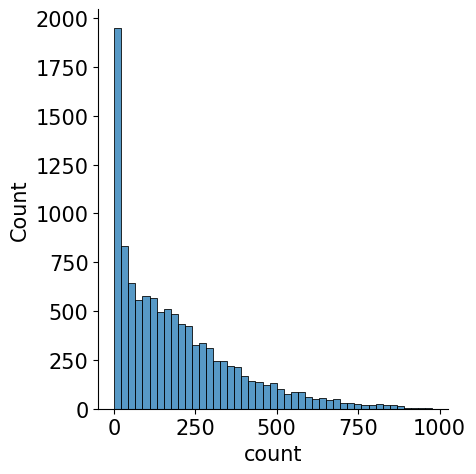

In [20]:
mpl.rc('font', size = 15) # 폰트 크기를 15로 설정
sns.displot(train['count'])

-  `count`가 0 근처에 몰려있음을 확인할 수 있다.😮❗
- 회귀 모델이 좋은 성능을 내려면 데이터가 정규분포 따르는 것이 좋다. ➡️ **로그 변환**

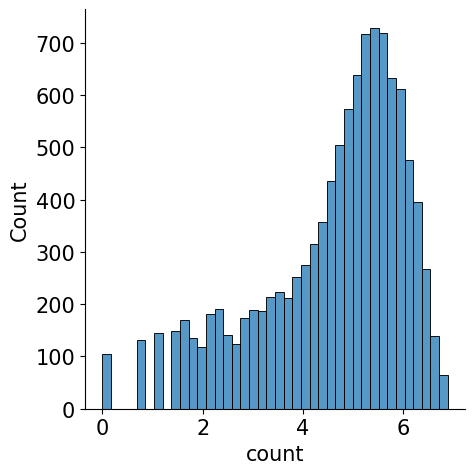

In [21]:
sns.displot(np.log(train['count']))

### 2-2-2. 막대 그래프 ✍🏻
- 연도, 월, 일, 시, 분, 초별로 총 여섯 가지의 평균 대여 수량을 막대 그래프로 그려보자
- 이것들은 범주형 데이터, 각 범주형 데이터에 따라 평균 대여 수량이 어떻게 다른지 파악하려고 한다.
    - 그래야 어떤 피처가 중요한지 알 수 있다.
    - 막대그래프는 `seaborn`의 `barplot()` 함수로 그릴 수 있다.

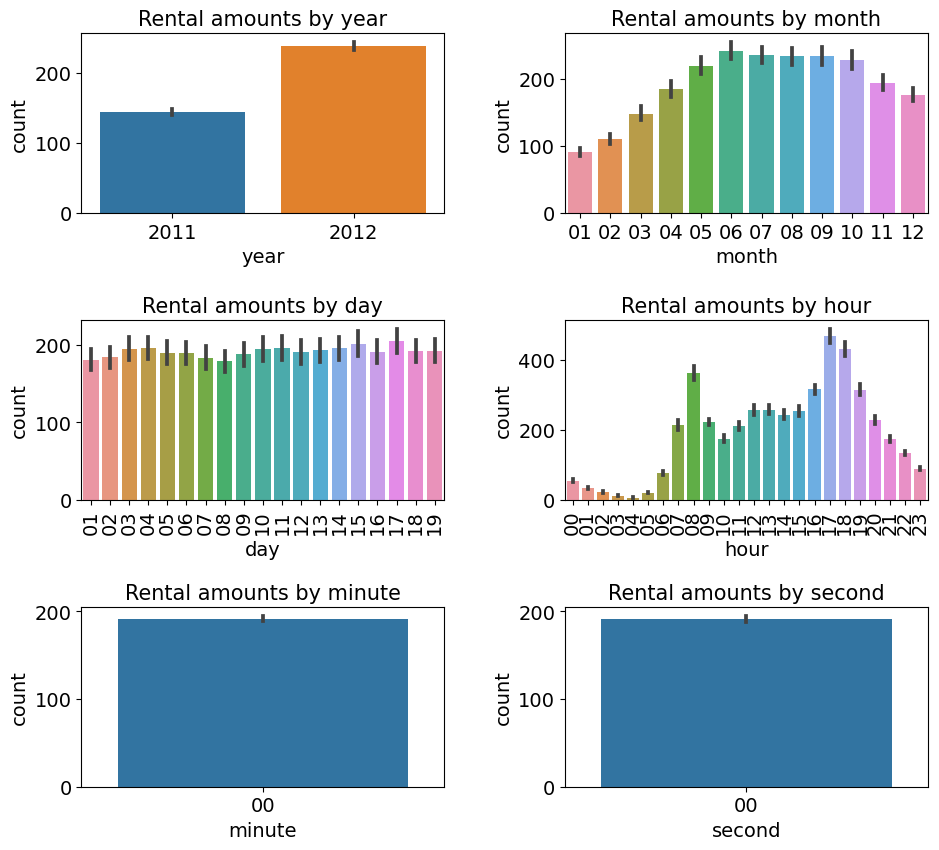

In [22]:
# 스탭 1: m행 n열 Figure 준비하기 #
mpl.rc('font', size = 14) # 폰트 크기 설정
mpl.rc('axes', titlesize = 15) # 각 축의 제목 크기 설정
figure, axes = plt.subplots(nrows = 3, ncols = 2) # 3행 2열 Figure 생성
plt.tight_layout() # 그래프 사이에 여백 확보
figure.set_size_inches(10, 9) # 전체 Figure 크기를 10x9 인치로 설정

# 스텝 2 : 각 축에 서브플롯 할당 #
# 각 축에 연도, 월, 일, 시간, 분, 초별 평균 대여 수량 막대 그래프 할당
sns.barplot(x='year', y='count', data=train, ax=axes[0, 0])
sns.barplot(x='month', y='count', data=train, ax=axes[0, 1])
sns.barplot(x='day', y='count', data=train, ax=axes[1, 0])
sns.barplot(x='hour', y='count', data=train, ax=axes[1, 1])
sns.barplot(x='minute', y='count', data=train, ax=axes[2, 0])
sns.barplot(x='second', y='count', data=train, ax=axes[2, 1])

# 스텝 3 : 세부 설정 #
# 3-1 : 서브플롯에 제목 달기
axes[0, 0].set(title='Rental amounts by year')
axes[0, 1].set(title='Rental amounts by month')
axes[1, 0].set(title='Rental amounts by day')
axes[1, 1].set(title='Rental amounts by hour')
axes[2, 0].set(title='Rental amounts by minute')
axes[2, 1].set(title='Rental amounts by second')

# 3-2 : 1행에 위치한 서브플롯들의 x축 라벨 90도 회전 #
axes[1, 0].tick_params(axis='x', labelrotation=90)
axes[1, 1].tick_params(axis='x', labelrotation=90)

### 💡INSIGHT
- 2011년보다 2012년에 대여가 더 많았다
- 평균 대여 수량은 6월에 가장 많고 1월에 가장 적다
    - 날씨가 따뜻할수록 대여 수량이 많다고 짐작할 수 있다.
- day는 19일까지만 있으므로 피처로 이용할 수 없다
- 사람들은 등학교 혹은 출퇴근 길에 자전거를 많이 이용한다고 짐작할 수 있다.
- 분별 초별은 아무런 정보가 없다


### 2-2-3. 박스플롯 ✍🏻 
- 범주형 데이터에 따른 수치형 데이터 정보를 나타낸다.
- 계절, 날씨, 공휴일, 근무일(범주형 데이터)별 대여 수량(수치형 데이터)을 박스플롯으로 그려보겠다.

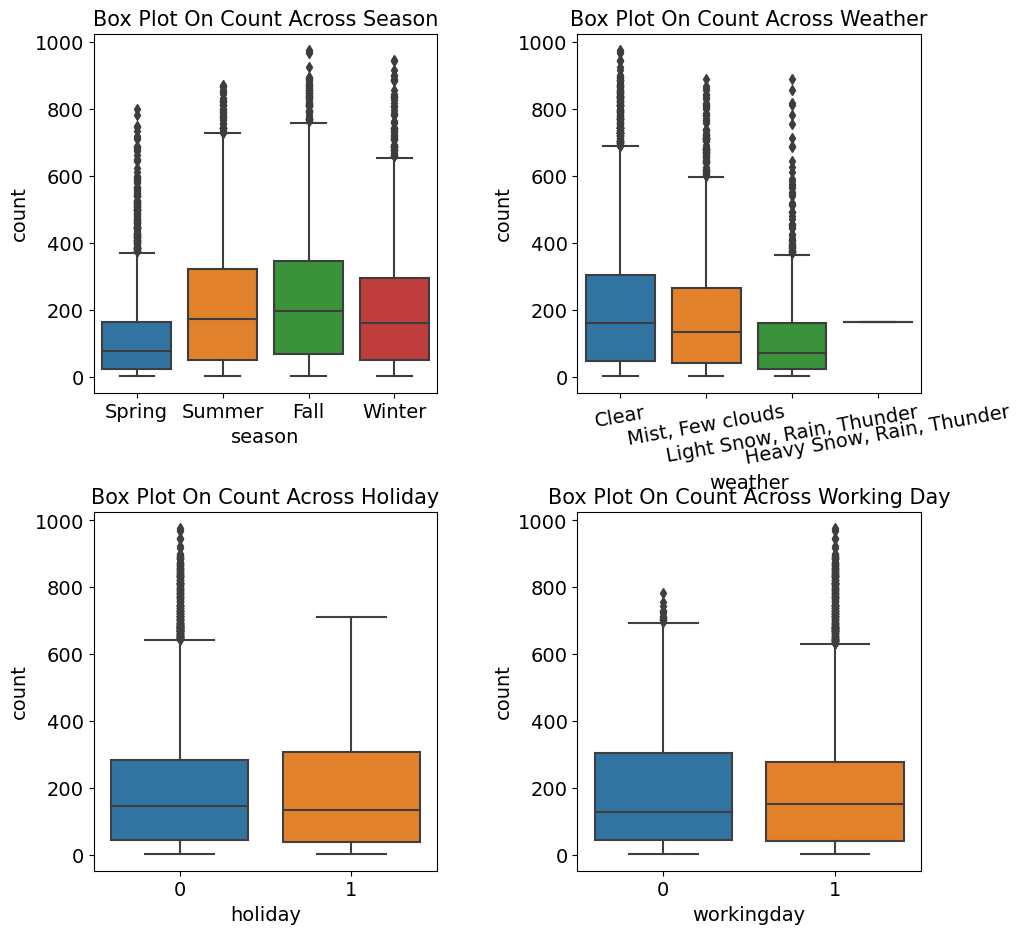

In [23]:
# 스텝 1 : m행 n열 Figure 준비 #
figure, axes = plt.subplots(nrows=2, ncols=2) # 2행 2열
plt.tight_layout()
figure.set_size_inches(10, 10)

# 스텝 2 : 서브플롯 할당 #
# 계절, 날씨, 공휴일, 근무일별 대여 수량 박스플롯
sns.boxplot(x='season', y='count', data=train, ax=axes[0, 0])
sns.boxplot(x='weather', y='count', data=train, ax=axes[0, 1])
sns.boxplot(x='holiday', y='count', data=train, ax=axes[1, 0])
sns.boxplot(x='workingday', y='count', data=train, ax=axes[1, 1])

# 스텝 3 : 세부 설정 #
# 3-1 : 서브플롯에 제목 달기 #
axes[0, 0].set(title='Box Plot On Count Across Season')
axes[0, 1].set(title='Box Plot On Count Across Weather')
axes[1, 0].set(title='Box Plot On Count Across Holiday')
axes[1, 1].set(title='Box Plot On Count Across Working Day')

# 3-2 : x축 라벨 겹침 해결 #
axes[0, 1].tick_params('x', labelrotation=10) # 10도 회전

### 💡INSIGHT
- 자전거 대여 수량은 봄에 가장 적고 가을에 가장 많다.
- 날씨가 좋을 때 대여 수량이 가장 많고, 안 좋을수록 수량이 적다
- 공휴일이 아닐 때 & 근무일일 때 이상치가 많다

### 2-2-4. 포인트 플롯 ✍🏻
- 근무일, 공휴일, 요일, 계절, 날씨에 따른 시간대별 평균 대여 수량을 그려보자

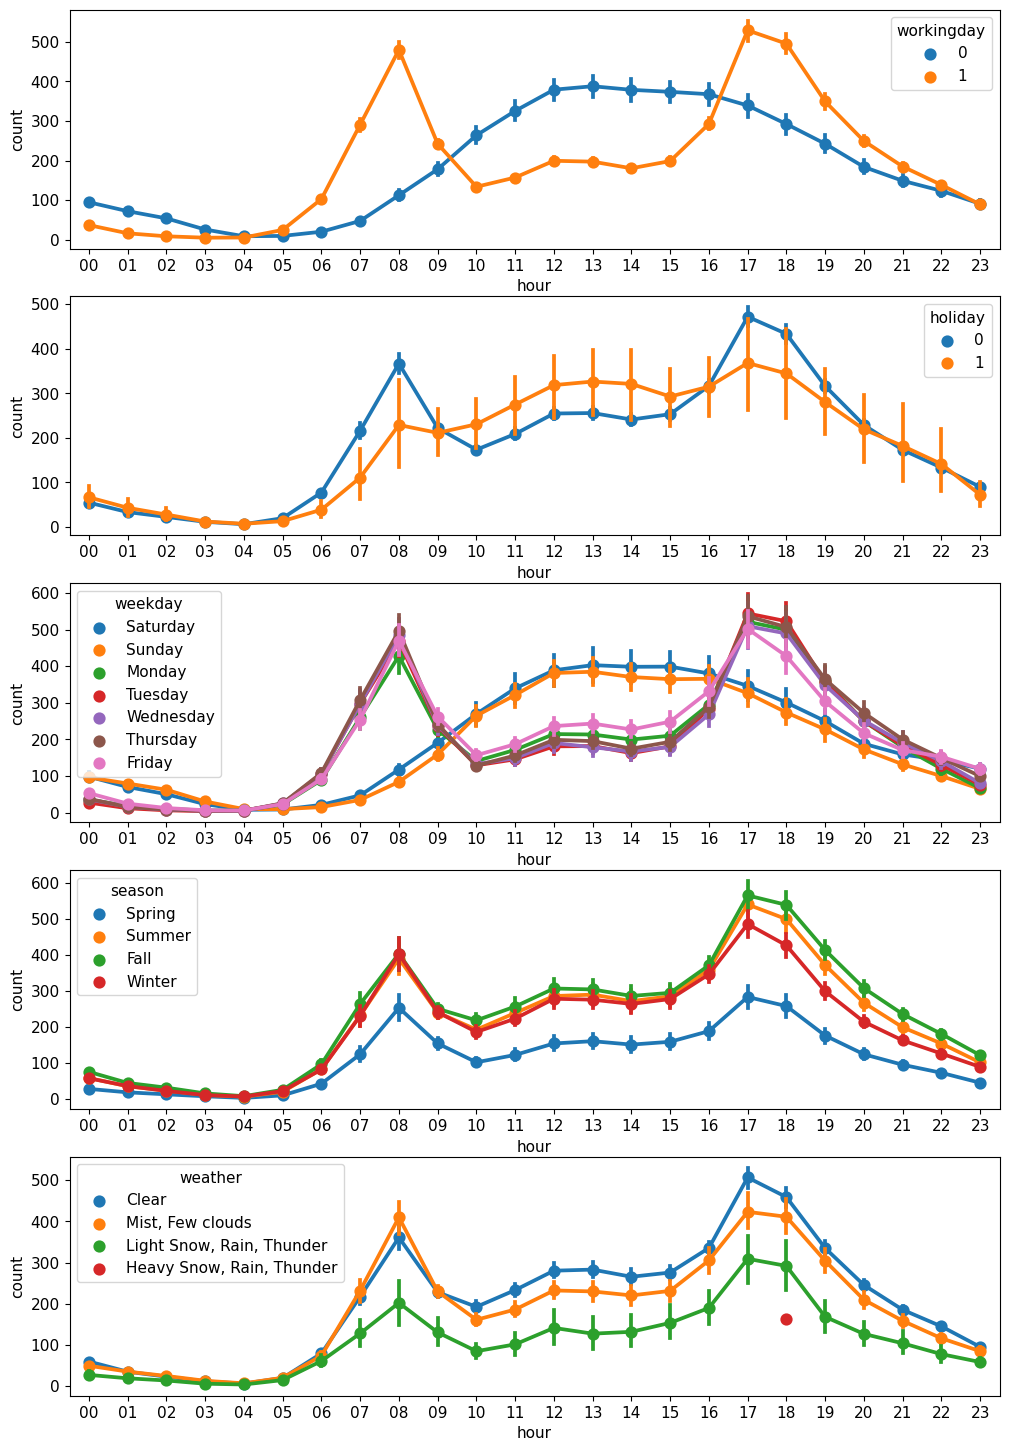

In [24]:
# 스텝 1 : m행 n열 Figure 준비 #
mpl.rc('font', size=11)
figure, axes = plt.subplots(nrows=5) # 5행 1열
figure.set_size_inches(12, 18)

# 스텝 2 : 서브플롯 할당 #
# 근무일, 공휴일, 요일, 계절, 날씨에 따른 시간대별 평균 대여 수량 포인트플롯
sns.pointplot(x='hour', y='count', data=train, hue='workingday', ax=axes[0])
sns.pointplot(x='hour', y='count', data=train, hue='holiday', ax=axes[1])
sns.pointplot(x='hour', y='count', data=train, hue='weekday', ax=axes[2])
sns.pointplot(x='hour', y='count', data=train, hue='season', ax=axes[3])
sns.pointplot(x='hour', y='count', data=train, hue='weather', ax=axes[4]);

### 💡INSIGHT
- 근무일에는 출퇴근 시간에 대여 수량이 많고 쉬는 날에는 오후 12~2시에 가장 많음
- 공휴일 여부, 요일에 따른 포인트 플롯도 비슷한 양상


### 2-2-5. 회귀선을 포함한 산점도 그래프
- 수치형 데이터인 온도, 체감 온도, 풍속, 습도별 대여 수량을 그려볼 것이다.

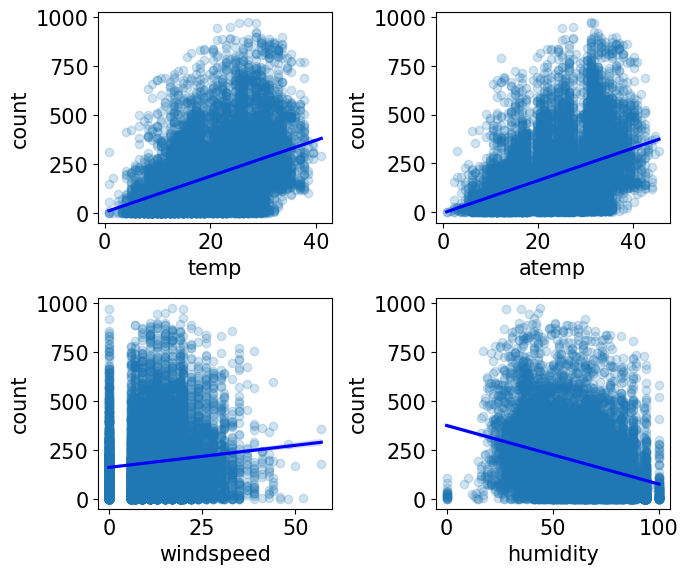

In [25]:
# 스텝 1 : m행 n열 Figure 준비
mpl.rc('font', size=15)
figure, axes = plt.subplots(nrows=2, ncols=2) # 2행 2열
plt.tight_layout()
figure.set_size_inches(7, 6)

# 스텝 2 : 서브플롯 할당
# 온도, 체감 온도, 풍속, 습도 별 대여 수량 산점도 그래프
sns.regplot(x='temp', y='count', data=train, ax=axes[0, 0], 
            scatter_kws={'alpha': 0.2}, line_kws={'color': 'blue'})
sns.regplot(x='atemp', y='count', data=train, ax=axes[0, 1], 
            scatter_kws={'alpha': 0.2}, line_kws={'color': 'blue'})
sns.regplot(x='windspeed', y='count', data=train, ax=axes[1, 0], 
            scatter_kws={'alpha': 0.2}, line_kws={'color': 'blue'})
sns.regplot(x='humidity', y='count', data=train, ax=axes[1, 1], 
            scatter_kws={'alpha': 0.2}, line_kws={'color': 'blue'});

### 💡INSIGHT
- 온도와 체감 온도가 높을수록 대여 수량이 많다.
- 습도는 낮을수록 대여 수량이 많다
- `windspeed`에는 결측값이 많다.
    - 풍속이 0인 데이터가 많은데, 실제 풍속이 0이 아니라 관측치가 없거나 오류이다.
    - 결측값이 많아서 그래프만으로 풍속과 대여 수량의 상관관계를 파악하기 힘들다.
    - 결측값을 다른 값으로 대체하거나 `windspeed` 피처를 삭제해야 한다


### 2-2-6. 히트맵
- `temp`, `atemp`, `humidity`, `windspeed`, `count`는 수치형 데이터
- 수치형 데이터끼리 어떤 상관관계가 있는지 알아보자.

In [26]:
# DataFrame 내의 피처 간 상관계수를 계산해 반환
train[['temp', 'atemp', 'humidity', 'windspeed', 'count']].corr()

,temp,atemp,humidity,windspeed,count
temp,1.000000,0.984948,-0.064949,-0.017852,0.394454
atemp,0.984948,1.000000,-0.043536,-0.057473,0.389784
humidity,-0.064949,-0.043536,1.000000,-0.318607,-0.317371
windspeed,-0.017852,-0.057473,-0.318607,1.000000,0.101369
count,0.394454,0.389784,-0.317371,0.101369,1.000000


- 히트맵은 데이터 간 관계를 색상으로 표현하여, 여러 데이터를 한눈에 비교하기에 좋다.
- 히트맵은 `seaborn`의 `heatmap()` 함수로 그릴 수 있다.

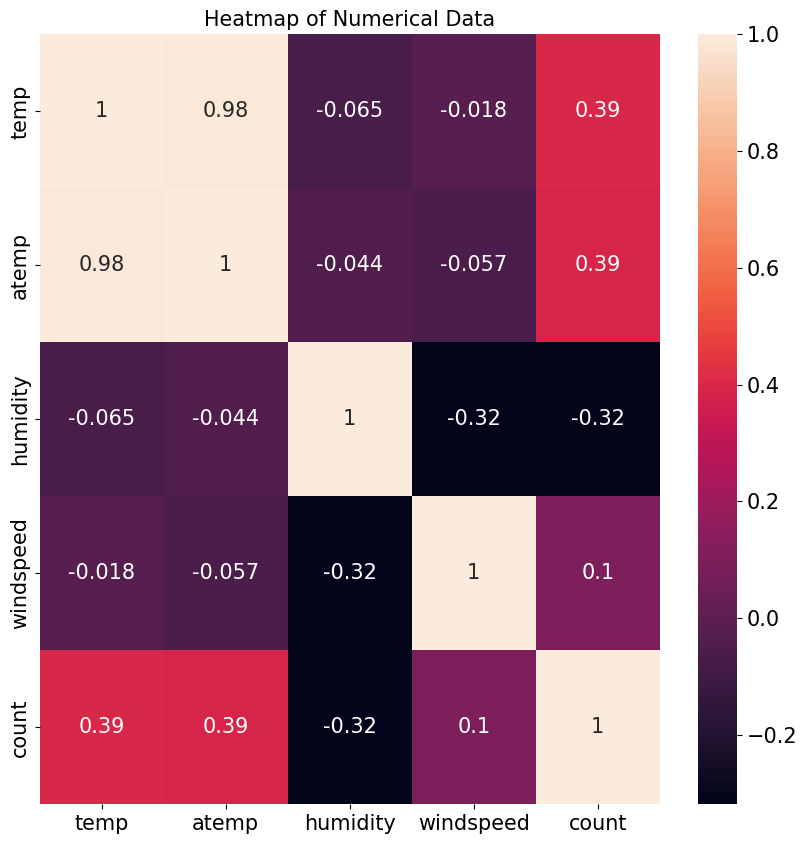

In [27]:
# 피처 간 상관관계 매트릭스
corrMat = train[['temp', 'atemp', 'humidity', 'windspeed', 'count']].corr() 
fig, ax= plt.subplots() 
fig.set_size_inches(10, 10)
sns.heatmap(corrMat, annot=True) # 상관관계 히트맵 그리기
ax.set(title='Heatmap of Numerical Data');

### 💡INSIGHT
- 풍속 `windspeed`과 대여 수량의 상관계수는 0.1이다.
- 성능을 높이기 위해 모델링 시 `windspeed` 피처는 제거할 것이다.